# Power grid example case 9


$\Gamma = 0$,

__case-9__

Perburbations = large

Splitting time-series according to perturbation points

$\Gamma = 0$,

Perburbations = large

Splitting time-series according to perturbation points

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

from os import path

## Loading data

In [2]:
folder_name = "case_9bus3gen"
folder_location = path.join("powergrid","Datasets", folder_name)

#### Reading time series data and skipping rows to sub sample

In [3]:
# #Trimming original time series to reduce the number of data points
# data_matrix_df_orig = pd.read_csv(path.join(folder_location, "{}_timeseries.csv".format(folder_name)))
# skip_n_rows_btw = 100
# rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

# data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

# data_matrix_df.to_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)), index=False)

In [4]:
data_matrix_df = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))

In [5]:
data_matrix_df

,time,PhaseGen1,PhaseGen2,PhaseGen3,PhaseGenTerm1,PhaseGenTerm2,PhaseGenTerm3,PhaseLoad1,PhaseLoad2,PhaseLoad3,...,ReactivePowerGen3,ReactivePowerGenTerm1,ReactivePowerGenTerm2,ReactivePowerGenTerm3,ReactivePowerLoad1,ReactivePowerLoad2,ReactivePowerLoad3,ReactivePowerLoad4,ReactivePowerLoad5,ReactivePowerLoad6
0,0.00000000,0.00000000,0.17493161,0.08962591,0.00000000,0.17493161,0.08962591,0.00000000,0.00000000,0.00000000,...,0.00000000,0.11406434,0.36587572,0.04021047,-0.02332537,-0.33622469,0.01221760,-0.37431258,0.07417147,-0.56924338
1,0.01000000,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,...,0.00408081,0.11556592,0.17895356,-0.01855028,-0.01531581,-0.32495717,-0.03722068,-0.35437914,-0.09930633,-0.54261054
2,0.02000000,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,...,0.00847182,0.11835349,0.19259077,-0.01466605,-0.01199942,-0.32110501,-0.03551509,-0.35872888,-0.09746084,-0.53519705
3,0.03000000,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,...,0.01412112,0.12245606,0.21057222,-0.00791273,-0.01047375,-0.31864729,-0.03227721,-0.35877318,-0.08818516,-0.53058690
4,0.04000000,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,...,0.02130979,0.12833871,0.23024559,0.00068762,-0.00930260,-0.31651464,-0.02888726,-0.35782105,-0.07734143,-0.52665247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,59.95710000,0.29325016,0.41653286,0.37830296,0.04793282,0.22283576,0.13762958,0.00908341,-0.01757547,0.08785886,...,0.10009800,0.20339066,0.35882050,0.09286775,-0.00000996,-0.29998492,0.00004152,-0.35001300,-0.00008141,-0.50000423
5997,59.96710000,0.29327502,0.41647430,0.37834082,0.04793890,0.22280045,0.13764053,0.00908580,-0.01757174,0.08786264,...,0.10012028,0.20340476,0.35876112,0.09289613,-0.00000486,-0.29998527,0.00005104,-0.35001766,-0.00012618,-0.50001479
5998,59.97710000,0.29329763,0.41642157,0.37837256,0.04794397,0.22276764,0.13764929,0.00908738,-0.01756906,0.08786503,...,0.10013931,0.20341795,0.35870942,0.09292057,-0.00000004,-0.29998576,0.00005936,-0.35002181,-0.00016655,-0.50002448
5999,59.98710000,0.29331786,0.41637491,0.37839818,0.04794804,0.22273756,0.13765588,0.00908818,-0.01756738,0.08786611,...,0.10015506,0.20343015,0.35866552,0.09294101,0.00000447,-0.29998639,0.00006644,-0.35002543,-0.00020235,-0.50003325


In [6]:
def column_label_changer(column_label):
    if "PhaseGenTerm" in column_label:
        new_label = "Phi_T_{}".format(column_label[-1])
    elif "PhaseGen" in column_label:
        new_label = "Phi_G_{}".format(column_label[-1])
    elif "PhaseLoad" in column_label:
        new_label = "Phi_L_{}".format(column_label[-1])
    elif "FreqGenTerm" in column_label:
        new_label = "om_T_{}".format(column_label[-1])
    elif "FreqGen" in column_label:
        new_label = "om_G_{}".format(column_label[-1])
    elif "FreqLoad" in column_label:
        new_label = "om_L_{}".format(column_label[-1])
    elif "ActivePowerGenTerm" in column_label:
        new_label = "P_T_{}".format(column_label[-1])
    elif "ActivePowerGen" in column_label:
        new_label = "P_G_{}".format(column_label[-1])
    elif "ActivePowerLoad" in column_label:
        new_label = "P_L_{}".format(column_label[-1])
    elif "ReactivePowerGenTerm" in column_label:
        new_label = "Q_T_{}".format(column_label[-1])
    elif "ReactivePowerGen" in column_label:
        new_label = "Q_G_{}".format(column_label[-1])
    elif "ReactivePowerLoad" in column_label:
        new_label = "Q_L_{}".format(column_label[-1])
    else:
        new_label = column_label
    return new_label

In [7]:
column_label_dict = {column: column_label_changer(column) for column in data_matrix_df.columns}
column_label_dict

{'time': 'time',
 'PhaseGen1': 'Phi_G_1',
 'PhaseGen2': 'Phi_G_2',
 'PhaseGen3': 'Phi_G_3',
 'PhaseGenTerm1': 'Phi_T_1',
 'PhaseGenTerm2': 'Phi_T_2',
 'PhaseGenTerm3': 'Phi_T_3',
 'PhaseLoad1': 'Phi_L_1',
 'PhaseLoad2': 'Phi_L_2',
 'PhaseLoad3': 'Phi_L_3',
 'PhaseLoad4': 'Phi_L_4',
 'PhaseLoad5': 'Phi_L_5',
 'PhaseLoad6': 'Phi_L_6',
 'FreqGen1': 'om_G_1',
 'FreqGen2': 'om_G_2',
 'FreqGen3': 'om_G_3',
 'FreqGenTerm1': 'om_T_1',
 'FreqGenTerm2': 'om_T_2',
 'FreqGenTerm3': 'om_T_3',
 'FreqLoad1': 'om_L_1',
 'FreqLoad2': 'om_L_2',
 'FreqLoad3': 'om_L_3',
 'FreqLoad4': 'om_L_4',
 'FreqLoad5': 'om_L_5',
 'FreqLoad6': 'om_L_6',
 'ActivePowerGen1': 'P_G_1',
 'ActivePowerGen2': 'P_G_2',
 'ActivePowerGen3': 'P_G_3',
 'ActivePowerGenTerm1': 'P_T_1',
 'ActivePowerGenTerm2': 'P_T_2',
 'ActivePowerGenTerm3': 'P_T_3',
 'ActivePowerLoad1': 'P_L_1',
 'ActivePowerLoad2': 'P_L_2',
 'ActivePowerLoad3': 'P_L_3',
 'ActivePowerLoad4': 'P_L_4',
 'ActivePowerLoad5': 'P_L_5',
 'ActivePowerLoad6': 'P_L_6',
 'Rea

In [8]:
# new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
#                    "om_0", "om_1", "om_2", "om_3","om_4", "om_5", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
#                    "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]

#Renaming the state variables for compactness
data_matrix_df.rename(columns= column_label_dict, inplace=True)

In [9]:
power_features = [feature for feature in data_matrix_df.columns if "P_" in feature]
freq_features = [feature for feature in data_matrix_df.columns if "om_" in feature]
phase_features = [feature for feature in data_matrix_df.columns if "Phi_" in feature]

K_features = [feature[2:] for feature in power_features]

In [10]:
#Removing Reactive power from the timeseries they are not needed for fitting 
non_reactive_columns = [column for column in data_matrix_df.columns if "Q" not in column]

data_matrix_df = data_matrix_df[non_reactive_columns]

In [11]:
data_matrix_df

,time,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,...,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
0,0.00000000,0.00000000,0.17493161,0.08962591,0.00000000,0.17493161,0.08962591,0.00000000,0.00000000,0.00000000,...,-0.00000000,-0.00000000,2.76314523,1.52994732,-0.00000000,-0.00000000,-1.52994732,-0.00000000,-2.76314523,-0.00000000
1,0.01000000,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,...,0.16830950,0.19305122,0.36446761,0.27562804,0.31250747,-0.53396275,0.16895517,-0.93976188,0.17747953,-0.83922543
2,0.02000000,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,...,0.24243021,0.23473523,0.17976611,0.18155204,0.27751241,-0.61090695,0.19886327,-0.82541167,0.19313714,-0.94948466
3,0.03000000,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,...,0.31286428,0.22010162,0.13270099,0.15349487,0.24228288,-0.65098373,0.18227255,-0.82087220,0.16257359,-1.00235042
4,0.04000000,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,...,0.38413657,0.19455355,0.10701043,0.13135462,0.20811093,-0.68382242,0.15900720,-0.84183515,0.13357609,-1.04068399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,59.95710000,0.29325016,0.41653286,0.37830296,0.04793282,0.22283576,0.13762958,0.00908341,-0.01757547,0.08785886,...,0.82779710,0.05083751,0.07092273,0.02259468,-0.00003723,-0.90005637,-0.00005946,-0.99986096,0.00028538,-1.24993021
5997,59.96710000,0.29327502,0.41647430,0.37834082,0.04793890,0.22280045,0.13764053,0.00908580,-0.01757174,0.08786264,...,0.82788788,0.05085471,0.07088291,0.02262641,-0.00002624,-0.90004243,-0.00004082,-0.99985879,0.00027384,-1.24992605
5998,59.97710000,0.29329763,0.41642157,0.37837256,0.04794397,0.22276764,0.13764929,0.00908738,-0.01756906,0.08786503,...,0.82796539,0.05087163,0.07084095,0.02265749,-0.00001566,-0.90002888,-0.00002287,-0.99985843,0.00025979,-1.24992304
5999,59.98710000,0.29331786,0.41637491,0.37839818,0.04794804,0.22273756,0.13765588,0.00908818,-0.01756738,0.08786611,...,0.82802955,0.05088810,0.07079749,0.02268759,-0.00000561,-0.90001587,-0.00000578,-0.99985976,0.00024358,-1.24992116


In [16]:
final_time = 20

In [17]:
data_matrix_df = data_matrix_df[data_matrix_df["time"] <= final_time]

<Axes: >

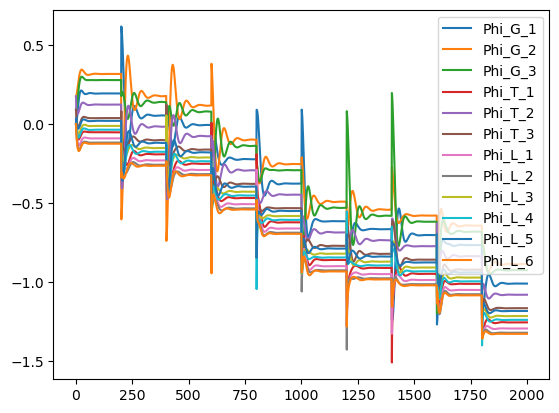

In [18]:
data_matrix_df[phase_features].plot()

In [19]:
data_matrix_df

,time,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,...,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
0,0.00000000,0.00000000,0.17493161,0.08962591,0.00000000,0.17493161,0.08962591,0.00000000,0.00000000,0.00000000,...,-0.00000000,-0.00000000,2.76314523,1.52994732,-0.00000000,-0.00000000,-1.52994732,-0.00000000,-2.76314523,-0.00000000
1,0.01000000,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,...,0.16830950,0.19305122,0.36446761,0.27562804,0.31250747,-0.53396275,0.16895517,-0.93976188,0.17747953,-0.83922543
2,0.02000000,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,...,0.24243021,0.23473523,0.17976611,0.18155204,0.27751241,-0.61090695,0.19886327,-0.82541167,0.19313714,-0.94948466
3,0.03000000,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,...,0.31286428,0.22010162,0.13270099,0.15349487,0.24228288,-0.65098373,0.18227255,-0.82087220,0.16257359,-1.00235042
4,0.04000000,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,...,0.38413657,0.19455355,0.10701043,0.13135462,0.20811093,-0.68382242,0.15900720,-0.84183515,0.13357609,-1.04068399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19.95910000,-1.01037582,-0.88696147,-0.92550651,-1.25569963,-1.08076596,-1.16605322,-1.29455362,-1.32121974,-1.21580613,...,0.82736986,0.05090054,0.07057412,0.02271798,-0.00001275,-0.90001347,-0.00000821,-0.99997101,0.00005669,-1.24998980
1997,19.96910000,-1.01036892,-0.88697331,-0.92550064,-1.25569781,-1.08077303,-1.16605156,-1.29455275,-1.32121883,-1.21580566,...,0.82738407,0.05090443,0.07056666,0.02272398,-0.00001041,-0.90001061,-0.00000450,-0.99997035,0.00005476,-1.24998877
1998,19.97910000,-1.01036256,-0.88698404,-0.92549586,-1.25569620,-1.08077965,-1.16605032,-1.29455205,-1.32121814,-1.21580545,...,0.82739598,0.05090834,0.07055873,0.02272978,-0.00000811,-0.90000781,-0.00000098,-0.99997008,0.00005231,-1.24998794
1999,19.98910000,-1.01035676,-0.88699361,-0.92549217,-1.25569481,-1.08078575,-1.16604948,-1.29455153,-1.32121765,-1.21580550,...,0.82740562,0.05091221,0.07055045,0.02273533,-0.00000586,-0.90000511,0.00000232,-0.99997019,0.00004939,-1.24998732


<Axes: >

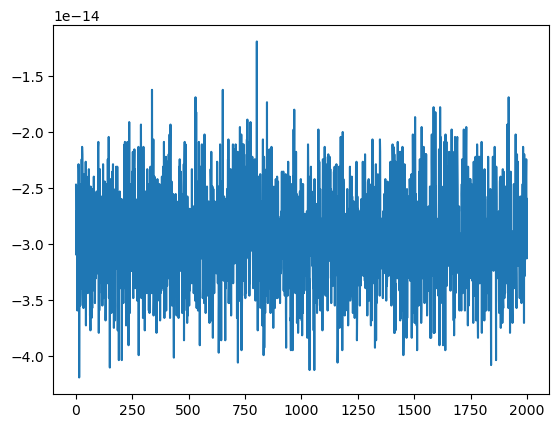

In [22]:
data_matrix_df[power_features].sum(axis=1).plot()

### Reading gamma values 

In [23]:
gamma_df = pd.read_csv(path.join(folder_location, "{}_gamma.csv".format(folder_name)), names=K_features)

In [24]:
gamma_df

,G_1,G_2,G_3,T_1,T_2,T_3,L_1,L_2,L_3,L_4,L_5,L_6
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
6,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
7,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
8,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
9,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000


### Splitting the time-series with respect to the perturbation points

In [25]:
#Getting perturbations time points
perturbation_points_df = pd.read_csv(path.join(folder_location, "{}_timepoints.csv".format(folder_name)))

perturbation_points_df = perturbation_points_df[perturbation_points_df["Perturbation timepoints"] <= final_time]

In [26]:
perturbation_time_point_list = perturbation_points_df["Perturbation timepoints"]
# perturbation_time_point_list

In [27]:
perturbation_time_point_list

0      0
1      2
2      4
3      6
4      8
5     10
6     12
7     14
8     16
9     18
10    20
Name: Perturbation timepoints, dtype: int64

In [28]:
#Splitting the data_matrix with the timeseries into a list of timeseries dataframes based on where the perturbation is introduced
#The purpose of this step is to smoothen each of perturbation segment independently using splines and find the derivaties
#This will avoid jumps in the derivative due to the discontinuity at the perturbanc time point

data_matrix_df_list =[data_matrix_df[(ind_i < data_matrix_df["time"]) & (data_matrix_df["time"] < ind_j) ] 
                       for ind_i, ind_j in zip(perturbation_time_point_list[:-1], perturbation_time_point_list[1:])]


data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_df_appended

,time,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,...,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
0,0.01000000,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,...,0.16830950,0.19305122,0.36446761,0.27562804,0.31250747,-0.53396275,0.16895517,-0.93976188,0.17747953,-0.83922543
1,0.02000000,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,...,0.24243021,0.23473523,0.17976611,0.18155204,0.27751241,-0.61090695,0.19886327,-0.82541167,0.19313714,-0.94948466
2,0.03000000,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,...,0.31286428,0.22010162,0.13270099,0.15349487,0.24228288,-0.65098373,0.18227255,-0.82087220,0.16257359,-1.00235042
3,0.04000000,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,...,0.38413657,0.19455355,0.10701043,0.13135462,0.20811093,-0.68382242,0.15900720,-0.84183515,0.13357609,-1.04068399
4,0.05000000,0.04458825,0.20608535,0.12856502,-0.06720989,0.06523271,-0.00276341,-0.09346844,-0.11632975,-0.03576394,...,0.45478515,0.16846372,0.08704754,0.10919858,0.17561271,-0.71478822,0.13362895,-0.86743785,0.10640146,-1.07392133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,19.95910000,-1.01037582,-0.88696147,-0.92550651,-1.25569963,-1.08076596,-1.16605322,-1.29455362,-1.32121974,-1.21580613,...,0.82736986,0.05090054,0.07057412,0.02271798,-0.00001275,-0.90001347,-0.00000821,-0.99997101,0.00005669,-1.24998980
1995,19.96910000,-1.01036892,-0.88697331,-0.92550064,-1.25569781,-1.08077303,-1.16605156,-1.29455275,-1.32121883,-1.21580566,...,0.82738407,0.05090443,0.07056666,0.02272398,-0.00001041,-0.90001061,-0.00000450,-0.99997035,0.00005476,-1.24998877
1996,19.97910000,-1.01036256,-0.88698404,-0.92549586,-1.25569620,-1.08077965,-1.16605032,-1.29455205,-1.32121814,-1.21580545,...,0.82739598,0.05090834,0.07055873,0.02272978,-0.00000811,-0.90000781,-0.00000098,-0.99997008,0.00005231,-1.24998794
1997,19.98910000,-1.01035676,-0.88699361,-0.92549217,-1.25569481,-1.08078575,-1.16604948,-1.29455153,-1.32121765,-1.21580550,...,0.82740562,0.05091221,0.07055045,0.02273533,-0.00000586,-0.90000511,0.00000232,-0.99997019,0.00004939,-1.24998732


#### Loading admittance matrix, Y

In [29]:
admittance_Y_df = pd.read_csv(path.join(folder_location, "{}_Y.csv".format(folder_name)), names=K_features)
admittance_Y_df.set_index(pd.Index(K_features), inplace=True)
for column in admittance_Y_df.columns:
    admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))

In [30]:
admittance_Y_df

,G_1,G_2,G_3,T_1,T_2,T_3,L_1,L_2,L_3,L_4,L_5,L_6
G_1,0-2.5489j,0,0,-0+2.5489j,0,0,0,0,0,0,0,0
G_2,0,0-8.0965j,0,0,-0+8.0965j,0,0,0,0,0,0,0
G_3,0,0,0-3.4729j,0,0,-0+3.4729j,0,0,0,0,0,0
T_1,-0+2.5489j,0,0,0-19.91j,0,0,0+17.361j,0,0,0,0,0
T_2,0,-0+8.0965j,0,0,0-24.096j,0,0,0,0,0,0+16j,0
T_3,0,0,-0+3.4729j,0,0,0-20.538j,0,0,0+17.065j,0,0,0
L_1,0,0,0,0+17.361j,0,0,0-39.828j,0+10.87j,0,0,0,0+11.765j
L_2,0,0,0,0,0,0,0+10.87j,0-16.494j,0+5.8824j,0,0,0
L_3,0,0,0,0,0,0+17.065j,0,0+5.8824j,0-32.584j,0+9.9206j,0,0
L_4,0,0,0,0,0,0,0,0,0+9.9206j,0-23.631j,0+13.889j,0


#### Loading static parameters

In [31]:
static_param_df = pd.read_csv(path.join(folder_location, "{}_staticparams.csv".format(folder_name)))

In [32]:
static_param_df

,V,A,omega_R,D,H
0,1.00000000,0.67000000,376.99111843,50,2.68000000
1,1.00000000,1.63000000,376.99111843,50,6.52000000
2,1.00000000,0.85000000,376.99111843,50,3.40000000
3,1.00000000,-0.00000000,376.99111843,50,0.00000000
4,1.00000000,-0.00000000,376.99111843,50,0.00000000
5,1.00000000,-0.00000000,376.99111843,50,0.00000000
6,0.99342989,-0.00000000,376.99111843,50,0.00000000
7,0.99134309,-0.90000000,376.99111843,50,0.00000000
8,1.00166406,-0.00000000,376.99111843,50,0.00000000
9,0.98769649,-1.00000000,376.99111843,50,0.00000000


#### Loading coupling matrix, K

In [33]:
coupling_K_df = pd.read_csv(path.join(folder_location, "{}_K.csv".format(folder_name)), names=K_features)
coupling_K_df.set_index(pd.Index(K_features), inplace=True)

In [34]:
coupling_K_df

,G_1,G_2,G_3,T_1,T_2,T_3,L_1,L_2,L_3,L_4,L_5,L_6
G_1,0.00000000,0.00000000,0.00000000,2.75860000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
G_2,0.00000000,0.00000000,0.00000000,0.00000000,8.46240000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
G_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,3.56840000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
T_1,2.75860000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,17.24700000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
T_2,0.00000000,8.46240000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,15.87600000,0.00000000
T_3,0.00000000,0.00000000,3.56840000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,17.09300000,0.00000000,0.00000000,0.00000000
L_1,0.00000000,0.00000000,0.00000000,17.24700000,0.00000000,0.00000000,0.00000000,10.70500000,0.00000000,0.00000000,0.00000000,11.37800000
L_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,10.70500000,0.00000000,5.84110000,0.00000000,0.00000000,0.00000000
L_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,17.09300000,0.00000000,5.84110000,0.00000000,9.81490000,0.00000000,0.00000000
L_4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,9.81490000,0.00000000,13.61200000,0.00000000


In [35]:
coupling_matrix_true = coupling_K_df .to_numpy()
coupling_matrix_true

array([[ 0.    ,  0.    ,  0.    ,  2.7586,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  8.4624,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  3.5684,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 2.7586,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , 17.247 ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  8.4624,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    , 15.876 ,  0.    ],
       [ 0.    ,  0.    ,  3.5684,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    , 17.093 ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , 17.247 ,  0.    ,  0.    ,  0.    ,
        10.705 ,  0.    ,  0.    ,  0.    , 11.378 ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , 10.705 ,
         0.    ,  5.8411,  0.    ,  0.    ,  0.    ],


## Forming candidate library for powersystems

In [36]:
gamma_df

,G_1,G_2,G_3,T_1,T_2,T_3,L_1,L_2,L_3,L_4,L_5,L_6
0,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
5,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
6,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
7,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000,0.00000000
8,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000,0.00000000
9,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-3.14160000,0.00000000,0.00000000


In [37]:
gamma_matrix = gamma_df.to_numpy()
admittance_Y_matrix = admittance_Y_df.to_numpy()

gamma_matrix

array([[-3.1416,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    , -3.1416,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -3.1416,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , -3.1416,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    , -3.1416,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -3.1416,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , -3.1416,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        -3.1416,  0.    ,  0.    ,  0.    ,  0.    ],


In [38]:
coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
# coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
# coupling_matrix_init[3,:] = 1

coupling_matrix_init = np.triu(coupling_matrix_init, 0)
coupling_matrix_init
sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Defining the sin interaction terms 

In [39]:
from dae_finder import FeatureCouplingTransformer

def coup_fun_sin_diff(x,y,i,j,gam_matrix):
    return np.sin(x-y- gam_matrix[i,j])

def coup_namer_sin_diff(x,y,i,j,gam_matrix=None):
    return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)


# def coup_fun_diff(x,y,i,j,gam_matrix):
#     return x-y- gam_matrix[i,j]

# def coup_namer_diff(x,y,i,j,gam_matrix):
#     return "{}-{} -gamma_{},{}".format(x,y,i,j)

transfomrer_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                           coupling_func= coup_fun_sin_diff,
                                           coupling_namer= coup_namer_sin_diff,
                                           coupling_func_args={"gam_matrix":gamma_matrix},
                                              return_df=True)

# transformer_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
#                                            coupling_func= coup_fun_diff,
#                                            coupling_namer= coup_namer_diff,
#                                            coupling_func_args={"gam_matrix":gamma_matrix},
#                                               return_df=True)

In [40]:
#Creating library with sin(load angle difference)
sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df_appended.drop(["time"], axis=1))
# sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))

cop_ind = transfomrer_sin_diff.coupled_indices_list

# #Creating library with load angle difference
# diff_library = transformer_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))


In [41]:
sin_diff_library

,"sin( Phi_G_1-Phi_G_1 -gamma_0,0 )","sin( Phi_G_1-Phi_G_2 -gamma_0,1 )","sin( Phi_G_1-Phi_G_3 -gamma_0,2 )","sin( Phi_G_1-Phi_T_1 -gamma_0,3 )","sin( Phi_G_1-Phi_T_2 -gamma_0,4 )","sin( Phi_G_1-Phi_T_3 -gamma_0,5 )","sin( Phi_G_1-Phi_L_1 -gamma_0,6 )","sin( Phi_G_1-Phi_L_2 -gamma_0,7 )","sin( Phi_G_1-Phi_L_3 -gamma_0,8 )","sin( Phi_G_1-Phi_L_4 -gamma_0,9 )",...,"sin( Phi_L_3-Phi_L_3 -gamma_8,8 )","sin( Phi_L_3-Phi_L_4 -gamma_8,9 )","sin( Phi_L_3-Phi_L_5 -gamma_8,10 )","sin( Phi_L_3-Phi_L_6 -gamma_8,11 )","sin( Phi_L_4-Phi_L_4 -gamma_9,9 )","sin( Phi_L_4-Phi_L_5 -gamma_9,10 )","sin( Phi_L_4-Phi_L_6 -gamma_9,11 )","sin( Phi_L_5-Phi_L_5 -gamma_10,10 )","sin( Phi_L_5-Phi_L_6 -gamma_10,11 )","sin( Phi_L_6-Phi_L_6 -gamma_11,11 )"
0,-0.00000735,-0.17362127,-0.08931107,0.00981735,-0.09676976,-0.04093660,0.02246012,0.04151740,-0.01497304,0.01386648,...,-0.00000735,0.02883652,-0.01942355,0.06608486,-0.00000735,-0.04824656,0.03728389,-0.00000735,0.08545348,-0.00000735
1,-0.00000735,-0.17189669,-0.08852207,0.03264336,-0.07438584,-0.01877459,0.05106241,0.07205705,0.00603090,0.03018528,...,-0.00000735,0.02415658,-0.01907372,0.07752549,-0.00000735,-0.04322034,0.05341898,-0.00000735,0.09652770,-0.00000735
2,-0.00000735,-0.16897156,-0.08723098,0.05886282,-0.05614430,0.00286673,0.08027288,0.10182568,0.03014880,0.05349370,...,-0.00000735,0.02336375,-0.02010497,0.08357764,-0.00000735,-0.04345852,0.06027282,-0.00000735,0.10359538,-0.00000735
3,-0.00000735,-0.16516600,-0.08562652,0.08552720,-0.03828150,0.02510128,0.10933523,0.13136476,0.05523796,0.07843865,...,-0.00000735,0.02325112,-0.02184008,0.08785312,-0.00000735,-0.04507975,0.06466814,-0.00000735,0.10958780,-0.00000735
4,-0.00000735,-0.16079600,-0.08387810,0.11156540,-0.02064299,0.04733397,0.13761856,0.16022441,0.08026575,0.10335112,...,-0.00000735,0.02318173,-0.02384194,0.09130913,-0.00000735,-0.04701068,0.06819970,-0.00000735,0.11502552,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-0.00000735,-0.12310130,-0.08476746,0.24287045,0.07033202,0.15504934,0.28036832,0.30586222,0.20398844,0.22741782,...,-0.00000735,0.02399258,-0.03219159,0.11231020,-0.00000735,-0.05616247,0.08843708,-0.00000735,0.14423991,-0.00000735
1995,-0.00000735,-0.12308271,-0.08476644,0.24287537,0.07034596,0.15505452,0.28037411,0.30586792,0.20399473,0.22742669,...,-0.00000735,0.02399527,-0.03218691,0.11231148,-0.00000735,-0.05616048,0.08843568,-0.00000735,0.14423655,-0.00000735
1996,-0.00000735,-0.12306574,-0.08476486,0.24287999,0.07035891,0.15505958,0.28037955,0.30587332,0.20400076,0.22743508,...,-0.00000735,0.02399773,-0.03218266,0.11231256,-0.00000735,-0.05615869,0.08843432,-0.00000735,0.14423342,-0.00000735
1997,-0.00000735,-0.12305049,-0.08476276,0.24288427,0.07037079,0.15506448,0.28038461,0.30587838,0.20400649,0.22744293,...,-0.00000735,0.02399993,-0.03217888,0.11231343,-0.00000735,-0.05615711,0.08843300,-0.00000735,0.14423055,-0.00000735


In [47]:
# candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)

candidate_lib = pd.concat([data_matrix_df_appended.drop("time", axis=1), sin_diff_library], axis=1)

In [48]:
candidate_lib

,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,Phi_L_4,...,"sin( Phi_L_3-Phi_L_3 -gamma_8,8 )","sin( Phi_L_3-Phi_L_4 -gamma_8,9 )","sin( Phi_L_3-Phi_L_5 -gamma_8,10 )","sin( Phi_L_3-Phi_L_6 -gamma_8,11 )","sin( Phi_L_4-Phi_L_4 -gamma_9,9 )","sin( Phi_L_4-Phi_L_5 -gamma_9,10 )","sin( Phi_L_4-Phi_L_6 -gamma_9,11 )","sin( Phi_L_5-Phi_L_5 -gamma_10,10 )","sin( Phi_L_5-Phi_L_6 -gamma_10,11 )","sin( Phi_L_6-Phi_L_6 -gamma_11,11 )"
0,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,-0.01159698,...,-0.00000735,0.02883652,-0.01942355,0.06608486,-0.00000735,-0.04824656,0.03728389,-0.00000735,0.08545348,-0.00000735
1,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,-0.02155681,...,-0.00000735,0.02415658,-0.01907372,0.07752549,-0.00000735,-0.04322034,0.05341898,-0.00000735,0.09652770,-0.00000735
2,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,-0.03520362,...,-0.00000735,0.02336375,-0.02010497,0.08357764,-0.00000735,-0.04345852,0.06027282,-0.00000735,0.10359538,-0.00000735
3,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,-0.04797903,...,-0.00000735,0.02325112,-0.02184008,0.08785312,-0.00000735,-0.04507975,0.06466814,-0.00000735,0.10958780,-0.00000735
4,0.04458825,0.20608535,0.12856502,-0.06720989,0.06523271,-0.00276341,-0.09346844,-0.11632975,-0.03576394,-0.05894775,...,-0.00000735,0.02318173,-0.02384194,0.09130913,-0.00000735,-0.04701068,0.06819970,-0.00000735,0.11502552,-0.00000735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-1.01037582,-0.88696147,-0.92550651,-1.25569963,-1.08076596,-1.16605322,-1.29455362,-1.32121974,-1.21580613,-1.23980102,...,-0.00000735,0.02399258,-0.03219159,0.11231020,-0.00000735,-0.05616247,0.08843708,-0.00000735,0.14423991,-0.00000735
1995,-1.01036892,-0.88697331,-0.92550064,-1.25569781,-1.08077303,-1.16605156,-1.29455275,-1.32121883,-1.21580566,-1.23980323,...,-0.00000735,0.02399527,-0.03218691,0.11231148,-0.00000735,-0.05616048,0.08843568,-0.00000735,0.14423655,-0.00000735
1996,-1.01036256,-0.88698404,-0.92549586,-1.25569620,-1.08077965,-1.16605032,-1.29455205,-1.32121814,-1.21580545,-1.23980548,...,-0.00000735,0.02399773,-0.03218266,0.11231256,-0.00000735,-0.05615869,0.08843432,-0.00000735,0.14423342,-0.00000735
1997,-1.01035676,-0.88699361,-0.92549217,-1.25569481,-1.08078575,-1.16604948,-1.29455153,-1.32121765,-1.21580550,-1.23980774,...,-0.00000735,0.02399993,-0.03217888,0.11231343,-0.00000735,-0.05615711,0.08843300,-0.00000735,0.14423055,-0.00000735


### Removing zero features

In [49]:
non_zero_column_series = (candidate_lib**2).sum() > 0.00001
non_zero_column_series
non_columns = [column for column in candidate_lib if non_zero_column_series[column]]

candidate_lib = candidate_lib[non_columns]

## Smoothening data and finding derivatives using splines

In [50]:
from dae_finder import add_noise_to_df

noise_perc = 0
# data_matrix_df_list = [data_matrix_df]
num_time_points = len(data_matrix_df_list[0])
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["time"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["time"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [51]:
from dae_finder import smooth_data

# Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix, domain_var="time", derr_order=1, noise_perc=noise_perc) for
                              data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
# if "time" in data_matrix_df_smooth:
#     data_matrix_df_smooth = data_matrix_df_smooth.drop("time", axis=1)

In [52]:
(data_matrix_df_smooth - data_matrix_df_appended).sum()

time      -0.00000000
Phi_G_1   -0.00000000
Phi_G_2    0.00000000
Phi_G_3   -0.00000000
Phi_T_1   -0.00000000
Phi_T_2   -0.00000000
Phi_T_3   -0.00000000
Phi_L_1   -0.00000000
Phi_L_2   -0.00000000
Phi_L_3   -0.00000000
Phi_L_4   -0.00000000
Phi_L_5   -0.00000000
Phi_L_6   -0.00000000
om_G_1     0.00000000
om_G_2     0.00000000
om_G_3     0.00000000
om_T_1    -0.00000000
om_T_2     0.00000000
om_T_3    -0.00000000
om_L_1     0.00000000
om_L_2     0.00000000
om_L_3    -0.00000000
om_L_4    -0.00000000
om_L_5     0.00000000
om_L_6     0.00000000
P_G_1      0.00000000
P_G_2      0.00000000
P_G_3      0.00000000
P_T_1      0.00000000
P_T_2     -0.00000000
P_T_3      0.00000000
P_L_1     -0.00000000
P_L_2     -0.00000000
P_L_3      0.00000000
P_L_4      0.00000000
P_L_5     -0.00000000
P_L_6     -0.00000000
dtype: float64

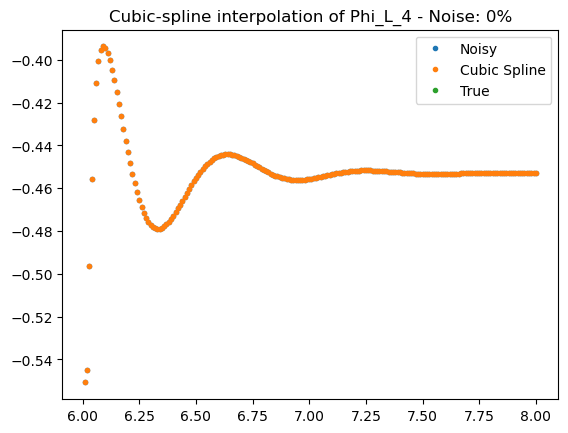

In [62]:
ind = 3
feature_ = "Phi_L_4"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["time"], data_matrix_df_list[ind][feature_], ".",
         data_matrix_smooth_df_list[ind]["time"],
         data_matrix_smooth_df_list[ind][feature_], ".",
         data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points]["time"],
         data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points][feature_], ".")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

## Finding Algebraic relationship

### Using sympy to find factors of redundant feature and refine the library

In [63]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df_appended.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_appended.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [64]:
data_matrix_df_smooth_appended.columns

Index(['time', 'Phi_G_1', 'd(Phi_G_1) /dt', 'Phi_G_2', 'd(Phi_G_2) /dt',
       'Phi_G_3', 'd(Phi_G_3) /dt', 'Phi_T_1', 'd(Phi_T_1) /dt', 'Phi_T_2',
       'd(Phi_T_2) /dt', 'Phi_T_3', 'd(Phi_T_3) /dt', 'Phi_L_1',
       'd(Phi_L_1) /dt', 'Phi_L_2', 'd(Phi_L_2) /dt', 'Phi_L_3',
       'd(Phi_L_3) /dt', 'Phi_L_4', 'd(Phi_L_4) /dt', 'Phi_L_5',
       'd(Phi_L_5) /dt', 'Phi_L_6', 'd(Phi_L_6) /dt', 'om_G_1',
       'd(om_G_1) /dt', 'om_G_2', 'd(om_G_2) /dt', 'om_G_3', 'd(om_G_3) /dt',
       'om_T_1', 'd(om_T_1) /dt', 'om_T_2', 'd(om_T_2) /dt', 'om_T_3',
       'd(om_T_3) /dt', 'om_L_1', 'd(om_L_1) /dt', 'om_L_2', 'd(om_L_2) /dt',
       'om_L_3', 'd(om_L_3) /dt', 'om_L_4', 'd(om_L_4) /dt', 'om_L_5',
       'd(om_L_5) /dt', 'om_L_6', 'd(om_L_6) /dt', 'P_G_1', 'd(P_G_1) /dt',
       'P_G_2', 'd(P_G_2) /dt', 'P_G_3', 'd(P_G_3) /dt', 'P_T_1',
       'd(P_T_1) /dt', 'P_T_2', 'd(P_T_2) /dt', 'P_T_3', 'd(P_T_3) /dt',
       'P_L_1', 'd(P_L_1) /dt', 'P_L_2', 'd(P_L_2) /dt', 'P_L_3',
       'd(P_L

In [65]:
data_matrix_features

Index(['time', 'Phi_G_1', 'Phi_G_2', 'Phi_G_3', 'Phi_T_1', 'Phi_T_2',
       'Phi_T_3', 'Phi_L_1', 'Phi_L_2', 'Phi_L_3', 'Phi_L_4', 'Phi_L_5',
       'Phi_L_6', 'om_G_1', 'om_G_2', 'om_G_3', 'om_T_1', 'om_T_2', 'om_T_3',
       'om_L_1', 'om_L_2', 'om_L_3', 'om_L_4', 'om_L_5', 'om_L_6', 'P_G_1',
       'P_G_2', 'P_G_3', 'P_T_1', 'P_T_2', 'P_T_3', 'P_L_1', 'P_L_2', 'P_L_3',
       'P_L_4', 'P_L_5', 'P_L_6'],
      dtype='object')

In [66]:
feature_list = list(data_matrix_features)
feature_list.remove('time')

feature_list

['Phi_G_1',
 'Phi_G_2',
 'Phi_G_3',
 'Phi_T_1',
 'Phi_T_2',
 'Phi_T_3',
 'Phi_L_1',
 'Phi_L_2',
 'Phi_L_3',
 'Phi_L_4',
 'Phi_L_5',
 'Phi_L_6',
 'om_G_1',
 'om_G_2',
 'om_G_3',
 'om_T_1',
 'om_T_2',
 'om_T_3',
 'om_L_1',
 'om_L_2',
 'om_L_3',
 'om_L_4',
 'om_L_5',
 'om_L_6',
 'P_G_1',
 'P_G_2',
 'P_G_3',
 'P_T_1',
 'P_T_2',
 'P_T_3',
 'P_L_1',
 'P_L_2',
 'P_L_3',
 'P_L_4',
 'P_L_5',
 'P_L_6']

In [67]:
refined_candid_lib = data_matrix_df_smooth_appended[feature_list]

In [68]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib), columns=s_scaler.feature_names_in_)

In [69]:
candidate_lib

,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,Phi_L_4,...,"sin( Phi_L_2-Phi_L_3 -gamma_7,8 )","sin( Phi_L_2-Phi_L_4 -gamma_7,9 )","sin( Phi_L_2-Phi_L_5 -gamma_7,10 )","sin( Phi_L_2-Phi_L_6 -gamma_7,11 )","sin( Phi_L_3-Phi_L_4 -gamma_8,9 )","sin( Phi_L_3-Phi_L_5 -gamma_8,10 )","sin( Phi_L_3-Phi_L_6 -gamma_8,11 )","sin( Phi_L_4-Phi_L_5 -gamma_9,10 )","sin( Phi_L_4-Phi_L_6 -gamma_9,11 )","sin( Phi_L_5-Phi_L_6 -gamma_10,11 )"
0,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,-0.01159698,...,-0.05647288,-0.02765889,-0.07585478,0.00962996,0.02883652,-0.01942355,0.06608486,-0.04824656,0.03728389,0.08545348
1,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,-0.02155681,...,-0.06604052,-0.04191740,-0.08506059,0.01151448,0.02415658,-0.01907372,0.07752549,-0.04322034,0.05341898,0.09652770
2,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,-0.03520362,...,-0.07178730,-0.04846423,-0.09182589,0.01182587,0.02336375,-0.02010497,0.08357764,-0.04345852,0.06027282,0.10359538
3,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,-0.04797903,...,-0.07640492,-0.05320111,-0.09816293,0.01148681,0.02325112,-0.02184008,0.08785312,-0.04507975,0.06466814,0.10958780
4,0.04458825,0.20608535,0.12856502,-0.06720989,0.06523271,-0.00276341,-0.09346844,-0.11632975,-0.03576394,-0.05894775,...,-0.08047868,-0.05735052,-0.10422041,0.01087046,0.02318173,-0.02384194,0.09130913,-0.04701068,0.06819970,0.11502552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-1.01037582,-0.88696147,-0.92550651,-1.25569963,-1.08076596,-1.16605322,-1.29455362,-1.32121974,-1.21580613,-1.23980102,...,-0.10521849,-0.08132879,-0.13717685,0.00713399,0.02399258,-0.03219159,0.11231020,-0.05616247,0.08843708,0.14423991
1995,-1.01036892,-0.88697331,-0.92550064,-1.25569781,-1.08077303,-1.16605156,-1.29455275,-1.32121883,-1.21580566,-1.23980323,...,-0.10521806,-0.08132568,-0.13717179,0.00713571,0.02399527,-0.03218691,0.11231148,-0.05616048,0.08843568,0.14423655
1996,-1.01036256,-0.88698404,-0.92549586,-1.25569620,-1.08077965,-1.16605032,-1.29455205,-1.32121814,-1.21580545,-1.23980548,...,-0.10521757,-0.08132275,-0.13716710,0.00713728,0.02399773,-0.03218266,0.11231256,-0.05615869,0.08843432,0.14423342
1997,-1.01035676,-0.88699361,-0.92549217,-1.25569481,-1.08078575,-1.16604948,-1.29455153,-1.32121765,-1.21580550,-1.23980774,...,-0.10521704,-0.08132002,-0.13716281,0.00713870,0.02399993,-0.03217888,0.11231343,-0.05615711,0.08843300,0.14423055


# Using Lasso

## Finding the conservation laws

In [243]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [252]:
# features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
#                     "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# num_nodes = 6
# power_features = ["P_{}".format(ind) for ind in range(num_nodes)]

# Mapping each power feature to possible expressions in the algebraic relationship. This is done by taking the power features and frequency
# feature from the candidate library
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

algebraic_model_lasso.fit(candidate_lib, scale_columns=True,
                          features_to_fit=power_features,
                          feature_to_library_map=feature_to_libr_map)


AlgModelFinder(alpha=0.3, fit_intercept=True)

In [253]:
# special_scaled_lib = scaled_cand_lib.drop(power_features, axis=1)
# special_scaled_lib = pd.concat((special_scaled_lib, candidate_lib[power_features]), axis=1)

In [254]:
# # features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
# #                     "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# # features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# # num_nodes = 6
# # power_features = ["P_{}".format(ind) for ind in range(num_nodes)]

# # Mapping each power feature to possible expressions in the algebraic relationship. This is done by taking the power features and frequency
# # feature from the candidate library

# seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


# algebraic_model_lasso = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

# # dynamic_model_th.fit(X=refined_candid_lib_appended,
# #                      scale_columns=False,
# #                      features_to_fit=dynamic_feat_to_fit,
# #                      feature_to_library_map=dynamic_feature_to_libr_map)
# feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

# algebraic_model_lasso.fit(X=candidate_lib,
#                                   scale_columns=True,
#                                   features_to_fit=power_features,
#                                   feature_to_library_map=feature_to_libr_map)


In [246]:
algebraic_model_lasso.best_models()

,P_G_1,P_G_2,P_G_3,P_L_5,P_L_1,P_L_6,P_T_1,P_L_2,P_L_4,P_L_3,P_T_2,P_T_3
Phi_G_1,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
Phi_G_2,-0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
Phi_G_3,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
Phi_T_1,0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
Phi_T_2,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...
"sin( Phi_L_3-Phi_L_6 -gamma_8,11 )",-0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
"sin( Phi_L_4-Phi_L_5 -gamma_9,10 )",0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.04081582,0.04608916,-0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_6 -gamma_9,11 )",-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000,0.06459147,0.01257375,0.00000000,-0.00000000
"sin( Phi_L_5-Phi_L_6 -gamma_10,11 )",-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,-0.07081034,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000


In [247]:
for feat in power_features:
    print(feat)
    print(algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1])

P_G_1
sin( Phi_G_1-Phi_T_1 -gamma_0,3 )   0.10708242
r2- metric                          0.91000000
Name: P_G_1, dtype: float64
P_G_2
sin( Phi_G_2-Phi_T_2 -gamma_1,4 )   0.27244749
r2- metric                          0.91000000
Name: P_G_2, dtype: float64
P_G_3
sin( Phi_G_3-Phi_T_3 -gamma_2,5 )   0.14300798
r2- metric                          0.91000000
Name: P_G_3, dtype: float64
P_T_1
r2- metric   0.60307602
Name: P_T_1, dtype: float64
P_T_2
r2- metric   0.29449378
Name: P_T_2, dtype: float64
P_T_3
r2- metric   0.18810553
Name: P_T_3, dtype: float64
P_L_1
r2- metric   0.65938059
Name: P_L_1, dtype: float64
P_L_2
r2- metric   0.59429409
Name: P_L_2, dtype: float64
P_L_3
r2- metric   0.42103625
Name: P_L_3, dtype: float64
P_L_4
r2- metric   0.56946266
Name: P_L_4, dtype: float64
P_L_5
r2- metric   0.66658764
Name: P_L_5, dtype: float64
P_L_6
r2- metric   0.65491007
Name: P_L_6, dtype: float64


### Checking model accuracy

### Extracting true models from the true coupling matrix

In [248]:
fitted_models = algebraic_model_lasso.best_models()[:-1]

In [249]:
true_models = pd.DataFrame(columns=fitted_models.columns, index=fitted_models.index)
true_models.fillna(0, inplace=True)
for ind_i, power_feat in enumerate(power_features):
    for ind_j in range(len(power_features)):
        if abs(coupling_matrix_true[ind_i, ind_j]) > 0.1:
            # true_models.loc[feat_name, power_feat] = coupling_matrix_true[ind_i, ind_j]
            low_ind = min(ind_i, ind_j)
            up_ind = max(ind_i, ind_j)
            feat_name = coup_namer_sin_diff(phase_features[low_ind], phase_features[up_ind],
                                        low_ind, up_ind)
            # print(feat_name)
            true_models.loc[feat_name, power_feat] = 20.0
            
            # print(ind_i, ind_j, coupling_matrix_true[ind_i, ind_j])
        # true_models[power_feat][feat_name] = "haha"
        # print(ind_i, ind_j, feat_name)
        # print(true_models[power_feat])

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_29000/581240014.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


In [250]:
# def compare_models(models_df_1, models_df_2, tol=1.e-5):
#     assert models_df_1.shape == models_df_2.shape, "both model dataframes should be of the same shape"
#     assert all(models_df_1.columns == models_df_2.columns) and all(models_df_1.index == models_df_2.index)

#     models_df_1[abs(models_df_1) > tol] = 1
#     models_df_1[abs(models_df_1) <= tol] = 0

#     models_df_2[abs(models_df_2) > tol] = 1
#     models_df_2[abs(models_df_2) <= tol] = 0

#     model_diff_df = models_df_1 - models_df_2

#     model_diff_df.loc["# incosistent terms"] = abs(model_diff_df).sum()

#     return model_diff_df

In [251]:
from dae_finder import compare_models_

compare_models_(true_models, fitted_models)

,P_G_1,P_G_2,P_G_3,P_L_5,P_L_1,P_L_6,P_T_1,P_L_2,P_L_4,P_L_3,P_T_2,P_T_3
Phi_G_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...
"sin( Phi_L_3-Phi_L_6 -gamma_8,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_5 -gamma_9,10 )",0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-1.00000000,0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_6 -gamma_9,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-1.00000000,-1.00000000,0.00000000,0.00000000
"sin( Phi_L_5-Phi_L_6 -gamma_10,11 )",0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [64]:
from sklearn.linear_model import Lasso

alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [66]:
coef_dict = dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))
coef_dict

In [67]:
seq_th_model.intercept_

In [68]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

In [69]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [70]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

### Full candidate library is unable to find the model 

In [42]:
alg_lasso.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [43]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

# Using Sequential Thresholding

## Finding the conservation laws

In [78]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression
lin_reg_model_arg = {"fit_intercept": True}
seq_th_model = sequentialThLin(custom_model=True,
                               custom_model_ob = lin_reg_model,
                               custom_model_arg= lin_reg_model_arg,
                              coef_threshold=0.1)
# seq_th_model = sequentialThLin(coef_threshold=0.1, alpha=0.1, fit_intercept=True)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

In [79]:
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

algebraic_model_th.fit(candidate_lib, scale_columns=False,
                       features_to_fit=power_features,
                       feature_to_library_map=feature_to_libr_map)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x12d582060>)

In [80]:
freq_features

['om_G_1',
 'om_G_2',
 'om_G_3',
 'om_T_1',
 'om_T_2',
 'om_T_3',
 'om_L_1',
 'om_L_2',
 'om_L_3',
 'om_L_4',
 'om_L_5',
 'om_L_6']

In [81]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

,P_G_1,P_G_2,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
Phi_G_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...
"sin( Phi_L_3-Phi_L_6 -gamma_8,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_5 -gamma_9,10 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,13.61205515,-13.61205515,0.00000000
"sin( Phi_L_4-Phi_L_6 -gamma_9,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_5-Phi_L_6 -gamma_10,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,6.00023087,-6.00023087


In [82]:
algebraic_model_th.get_fitted_intercepts()

{'P_G_1': 4.440892098500626e-16,
 'P_G_2': -4.440892098500626e-16,
 'P_G_3': -2.220446049250313e-16,
 'P_T_1': 2.2690183065776637e-15,
 'P_T_2': -2.9282132274488504e-15,
 'P_T_3': -2.3765711620882257e-15,
 'P_L_1': -1.1712636069360904e-14,
 'P_L_2': 5.88418203051333e-15,
 'P_L_3': -6.174748212739445e-15,
 'P_L_4': 3.3306690738754696e-16,
 'P_L_5': -5.792241686286559e-15,
 'P_L_6': -7.327471962526033e-15}

In [83]:
for feat in power_features:
    print(feat)
    print(algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat])>0.1])

P_G_1
sin( Phi_G_1-Phi_T_1 -gamma_0,3 )   2.54887928
r2- metric                          1.00000000
Name: P_G_1, dtype: float64
P_G_2
sin( Phi_G_2-Phi_T_2 -gamma_1,4 )   8.09647370
r2- metric                          1.00000000
Name: P_G_2, dtype: float64
P_G_3
sin( Phi_G_3-Phi_T_3 -gamma_2,5 )   3.47293478
r2- metric                          1.00000000
Name: P_G_3, dtype: float64
P_T_1
sin( Phi_G_1-Phi_T_1 -gamma_0,3 )   -2.54887928
sin( Phi_T_1-Phi_L_1 -gamma_3,6 )   17.24704677
r2- metric                           1.00000000
Name: P_T_1, dtype: float64
P_T_2
sin( Phi_G_2-Phi_T_2 -gamma_1,4 )    -8.09647370
sin( Phi_T_2-Phi_L_5 -gamma_4,10 )   15.87642320
r2- metric                            1.00000000
Name: P_T_2, dtype: float64
P_T_3
sin( Phi_G_3-Phi_T_3 -gamma_2,5 )   -3.47293478
sin( Phi_T_3-Phi_L_3 -gamma_5,8 )   17.09324334
r2- metric                           1.00000000
Name: P_T_3, dtype: float64
P_L_1
sin( Phi_T_1-Phi_L_1 -gamma_3,6 )    -17.24704677
sin( Phi_L_1-Phi_L_2 -g

### Checking model accuracy

### Extracting true models from the true coupling matrix

In [84]:
fitted_models = algebraic_model_th.best_models()[:-1]

In [85]:
true_models = pd.DataFrame(columns=fitted_models.columns, index=fitted_models.index)
true_models.fillna(0, inplace=True)
for ind_i, power_feat in enumerate(power_features):
    for ind_j in range(len(power_features)):
        if abs(coupling_matrix_true[ind_i, ind_j]) > 0.1:
            # true_models.loc[feat_name, power_feat] = coupling_matrix_true[ind_i, ind_j]
            low_ind = min(ind_i, ind_j)
            up_ind = max(ind_i, ind_j)
            feat_name = coup_namer_sin_diff(phase_features[low_ind], phase_features[up_ind],
                                        low_ind, up_ind)
            # print(feat_name)
            true_models.loc[feat_name, power_feat] = 20.0
            
            # print(ind_i, ind_j, coupling_matrix_true[ind_i, ind_j])
        # true_models[power_feat][feat_name] = "haha"
        # print(ind_i, ind_j, feat_name)
        # print(true_models[power_feat])

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_29000/581240014.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


In [86]:
# def compare_models(models_df_1, models_df_2, tol=1.e-5):
#     assert models_df_1.shape == models_df_2.shape, "both model dataframes should be of the same shape"
#     assert all(models_df_1.columns == models_df_2.columns) and all(models_df_1.index == models_df_2.index)

#     models_df_1[abs(models_df_1) > tol] = 1
#     models_df_1[abs(models_df_1) <= tol] = 0

#     models_df_2[abs(models_df_2) > tol] = 1
#     models_df_2[abs(models_df_2) <= tol] = 0

#     model_diff_df = models_df_1 - models_df_2

#     model_diff_df.loc["# incosistent terms"] = abs(model_diff_df).sum()

#     return model_diff_df

In [87]:
from dae_finder import compare_models_

compare_models_(true_models, fitted_models)

,P_G_1,P_G_2,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
Phi_G_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_G_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Phi_T_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...
"sin( Phi_L_3-Phi_L_6 -gamma_8,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_5 -gamma_9,10 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_4-Phi_L_6 -gamma_9,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
"sin( Phi_L_5-Phi_L_6 -gamma_10,11 )",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

<Axes: >

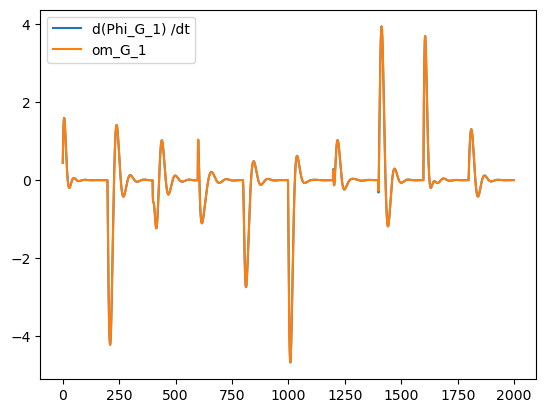

In [88]:
data_matrix_df_smooth_appended[['d(Phi_G_1) /dt', 'om_G_1']].plot()

<Axes: >

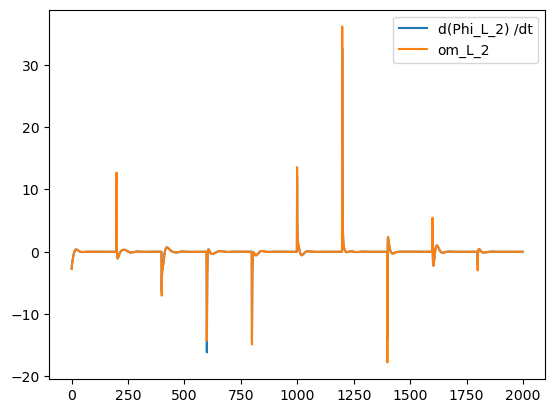

In [89]:
ind = "L_2"
data_matrix_df_smooth_appended[['d(Phi_{}) /dt'.format(ind), 'om_{}'.format(ind)]].plot()


In [92]:
ind = "L_2"


(abs(data_matrix_df_smooth_appended['d(Phi_{}) /dt'.format(ind)] - data_matrix_df_smooth_appended['om_{}'.format(ind)])).sum()


19.901750504745976

In [93]:
abs(data_matrix_df_smooth_appended['d(Phi_{}) /dt'.format(ind)]).sum()

370.1594372994303

In [94]:
scaled_refined_lib[power_features + freq_features]

,P_G_1,P_G_2,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,...,om_G_3,om_T_1,om_T_2,om_T_3,om_L_1,om_L_2,om_L_3,om_L_4,om_L_5,om_L_6
0,0.16357749,1.61230990,0.82384670,1.04799151,2.67977713,1.93573567,2.61632258,-3.23537497,1.27717013,-4.99462691,...,0.47720617,-1.03992128,-2.32247844,-1.89060644,-2.61632258,-2.21788456,-1.27717013,-0.32015232,-1.46982827,-1.90180351
1,0.54390621,2.04157514,1.18665509,1.27427593,1.32174463,1.27503997,2.32334275,-3.70159353,1.50325218,-4.38688080,...,0.85463143,-1.24082296,-0.99401550,-1.22008375,-2.32334275,-1.75166600,-1.50325218,-0.92789843,-1.59949954,-1.39132547
2,0.98077681,2.35831476,1.53141803,1.19483642,0.97569462,1.07799445,2.02840004,-3.94442582,1.37783922,-4.36275454,...,1.15815310,-1.13121094,-0.63029515,-1.01083964,-2.02840004,-1.50883371,-1.37783922,-0.95202468,-1.34638205,-1.14656766
3,1.42506067,2.64790677,1.88028389,1.05614702,0.78680271,0.92250350,1.74231140,-4.14340127,1.20197118,-4.47416795,...,1.39315185,-0.96166363,-0.41757243,-0.84271344,-1.74231140,-1.30985826,-1.20197118,-0.84061128,-1.10623418,-0.96909096
4,1.85891114,2.92037849,2.22609679,0.91451659,0.64002397,0.76690164,1.47023524,-4.33102852,1.01013132,-4.61024067,...,1.56435029,-0.78988140,-0.24650888,-0.67459668,-1.47023524,-1.12223101,-1.01013132,-0.70453856,-0.88118258,-0.81520877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,4.04672604,4.00638666,4.04983628,0.27631701,0.51890183,0.15954837,-0.00010675,-5.45334112,-0.00006203,-5.31462516,...,0.00077520,0.00013963,-0.00066773,0.00017335,0.00010675,0.00008159,0.00006203,-0.00015406,-0.00046951,-0.00004723
1995,4.04680799,4.00628941,4.04990582,0.27633814,0.51884700,0.15959050,-0.00008717,-5.45332380,-0.00003401,-5.31462162,...,0.00064265,0.00012406,-0.00062803,0.00013422,0.00008717,0.00006427,0.00003401,-0.00015760,-0.00045353,-0.00005200
1996,4.04688493,4.00620535,4.04996416,0.27635934,0.51878868,0.15963124,-0.00006788,-5.45330687,-0.00000742,-5.31462020,...,0.00051084,0.00010806,-0.00058344,0.00009604,0.00006788,0.00004734,0.00000742,-0.00015903,-0.00043318,-0.00005583
1997,4.04695631,4.00613461,4.05001132,0.27638035,0.51872779,0.15967021,-0.00004910,-5.45329050,0.00001753,-5.31462077,...,0.00038125,0.00009188,-0.00053482,0.00005918,0.00004910,0.00003097,-0.00001753,-0.00015845,-0.00040900,-0.00005873


In [99]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


ind = "L_2"
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)
# seq_th_model = sequentialThLin(model_id="RR", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])
seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])

# seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
# seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

Sequential threshold converged in 1 iterations


0.941877057028315

In [100]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

{'P_G_1': 0.0,
 'P_G_2': 0.0,
 'P_G_3': 0.0,
 'P_T_1': 0.0,
 'P_T_2': 0.0,
 'P_T_3': 0.0,
 'P_L_1': 0.0,
 'P_L_2': -0.9443640527280177,
 'P_L_3': 0.0,
 'P_L_4': 0.0,
 'P_L_5': 0.0,
 'P_L_6': 0.0,
 'Phi_G_1': 0.0,
 'Phi_G_2': 0.0,
 'Phi_G_3': 0.0,
 'Phi_T_1': 0.0,
 'Phi_T_2': 0.0,
 'Phi_T_3': 0.0,
 'Phi_L_1': 0.0,
 'Phi_L_2': 0.0,
 'Phi_L_3': 0.0,
 'Phi_L_4': 0.0,
 'Phi_L_5': 0.0,
 'Phi_L_6': 0.0,
 'om_G_1': 0.0,
 'om_G_2': 0.0,
 'om_G_3': 0.0,
 'om_T_1': 0.0,
 'om_T_2': 0.0,
 'om_T_3': 0.0,
 'om_L_1': 0.0,
 'om_L_2': 0.0,
 'om_L_3': 0.0,
 'om_L_4': 0.0,
 'om_L_5': 0.0,
 'om_L_6': 0.0}

### Discovering all frequencies

- Note that frequencies needs to be discovered only for non-generator nodes

In [120]:
thislist = ["apple", "banana", "cherry"]
try:
    thislist.remove("banana")
except ValueError:
    pass

print(thislist)

['apple', 'cherry']


In [117]:
list.remove?

Signature: list.remove(self, value, /)
Docstring:
Remove first occurrence of value.

Raises ValueError if the value is not present.
Type:      method_descriptor

In [113]:
#Collecting the feature names to fit: This will be d/dt(omega) for generators and omega for non-generator nodes

d_omega_gen_features = [feat for feat in data_matrix_df_smooth_appended.columns if "d(om_G" in feat]
freq_non_gen_features = [feat for feat in freq_features if "G" not in feat]

dynamic_feat_to_fit = d_omega_gen_features + freq_non_gen_features
dynamic_feat_to_fit

['d(om_G_1) /dt',
 'd(om_G_2) /dt',
 'd(om_G_3) /dt',
 'om_T_1',
 'om_T_2',
 'om_T_3',
 'om_L_1',
 'om_L_2',
 'om_L_3',
 'om_L_4',
 'om_L_5',
 'om_L_6']

In [126]:
combined_features = power_features + phase_features+ freq_features

dynamic_feature_to_libr_map = {feat: [comb_feat for comb_feat in combined_features if feat != comb_feat]
                              for feat in dynamic_feat_to_fit}

In [160]:
scaled_refined_lib[power_features + phase_features+ freq_features]

,P_G_1,P_G_2,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,...,om_G_3,om_T_1,om_T_2,om_T_3,om_L_1,om_L_2,om_L_3,om_L_4,om_L_5,om_L_6
0,0.16357749,1.61230990,0.82384670,1.04799151,2.67977713,1.93573567,2.61632258,-3.23537497,1.27717013,-4.99462691,...,0.47720617,-1.03992128,-2.32247844,-1.89060644,-2.61632258,-2.21788456,-1.27717013,-0.32015232,-1.46982827,-1.90180351
1,0.54390621,2.04157514,1.18665509,1.27427593,1.32174463,1.27503997,2.32334275,-3.70159353,1.50325218,-4.38688080,...,0.85463143,-1.24082296,-0.99401550,-1.22008375,-2.32334275,-1.75166600,-1.50325218,-0.92789843,-1.59949954,-1.39132547
2,0.98077681,2.35831476,1.53141803,1.19483642,0.97569462,1.07799445,2.02840004,-3.94442582,1.37783922,-4.36275454,...,1.15815310,-1.13121094,-0.63029515,-1.01083964,-2.02840004,-1.50883371,-1.37783922,-0.95202468,-1.34638205,-1.14656766
3,1.42506067,2.64790677,1.88028389,1.05614702,0.78680271,0.92250350,1.74231140,-4.14340127,1.20197118,-4.47416795,...,1.39315185,-0.96166363,-0.41757243,-0.84271344,-1.74231140,-1.30985826,-1.20197118,-0.84061128,-1.10623418,-0.96909096
4,1.85891114,2.92037849,2.22609679,0.91451659,0.64002397,0.76690164,1.47023524,-4.33102852,1.01013132,-4.61024067,...,1.56435029,-0.78988140,-0.24650888,-0.67459668,-1.47023524,-1.12223101,-1.01013132,-0.70453856,-0.88118258,-0.81520877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,4.04672604,4.00638666,4.04983628,0.27631701,0.51890183,0.15954837,-0.00010675,-5.45334112,-0.00006203,-5.31462516,...,0.00077520,0.00013963,-0.00066773,0.00017335,0.00010675,0.00008159,0.00006203,-0.00015406,-0.00046951,-0.00004723
1995,4.04680799,4.00628941,4.04990582,0.27633814,0.51884700,0.15959050,-0.00008717,-5.45332380,-0.00003401,-5.31462162,...,0.00064265,0.00012406,-0.00062803,0.00013422,0.00008717,0.00006427,0.00003401,-0.00015760,-0.00045353,-0.00005200
1996,4.04688493,4.00620535,4.04996416,0.27635934,0.51878868,0.15963124,-0.00006788,-5.45330687,-0.00000742,-5.31462020,...,0.00051084,0.00010806,-0.00058344,0.00009604,0.00006788,0.00004734,0.00000742,-0.00015903,-0.00043318,-0.00005583
1997,4.04695631,4.00613461,4.05001132,0.27638035,0.51872779,0.15967021,-0.00004910,-5.45329050,0.00001753,-5.31462077,...,0.00038125,0.00009188,-0.00053482,0.00005918,0.00004910,0.00003097,-0.00001753,-0.00015845,-0.00040900,-0.00005873


In [159]:
data_matrix_df_smooth_appended[d_omega_gen_features]

,d(om_G_1) /dt,d(om_G_2) /dt,d(om_G_3) /dt
0,41.24939097,26.45788151,34.48465551
1,33.14761944,20.98022627,28.12979888
2,25.38010344,16.44720292,22.23928283
3,18.16713314,12.51600992,16.75739862
4,11.73016205,8.89506499,11.68772171
...,...,...,...
1994,-0.00481268,0.01034945,-0.01096958
1995,-0.00529476,0.01108177,-0.01097142
1996,-0.00567809,0.01163421,-0.01084733
1997,-0.00596573,0.01201275,-0.01060723


In [169]:
refined_candid_lib_appended = pd.concat((scaled_refined_lib, data_matrix_df_smooth_appended[d_omega_gen_features]), axis=1)

refined_candid_lib_appended

,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,Phi_L_4,...,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6,d(om_G_1) /dt,d(om_G_2) /dt,d(om_G_3) /dt
0,0.00571917,0.45873339,0.23753831,-0.01961537,0.26141011,0.11371595,-0.05272634,-0.10278642,0.04540070,-0.03058519,...,1.93573567,2.61632258,-3.23537497,1.27717013,-4.99462691,1.46982827,-3.88544472,41.24939097,26.45788151,34.48465551
1,0.02175114,0.47070206,0.25196924,-0.06241546,0.21897021,0.07211839,-0.11085125,-0.16621628,0.00685115,-0.05685267,...,1.27503997,2.32334275,-3.70159353,1.50325218,-4.38688080,1.59949954,-4.39592275,33.14761944,20.98022627,28.12979888
2,0.04614659,0.48812495,0.27369341,-0.10546656,0.19631041,0.04064941,-0.16201103,-0.21910351,-0.03116770,-0.09284395,...,1.07799445,2.02840004,-3.94442582,1.37783922,-4.36275454,1.34638205,-4.64068056,25.38010344,16.44720292,22.23928283
3,0.07694684,0.50983177,0.30118813,-0.14317735,0.18139840,0.01430425,-0.20632445,-0.26496912,-0.06510084,-0.12653707,...,0.92250350,1.74231140,-4.14340127,1.20197118,-4.47416795,1.10623418,-4.81815726,18.16713314,12.51600992,16.75739862
4,0.11234098,0.53479246,0.33303230,-0.17467175,0.17191506,-0.00727113,-0.24406855,-0.30456708,-0.09416324,-0.15546532,...,0.76690164,1.47023524,-4.33102852,1.01013132,-4.61024067,0.88118258,-4.97203945,11.73016205,8.89506499,11.68772171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-2.54566196,-2.30166922,-2.39741382,-3.26343703,-2.84826336,-3.06814027,-3.38039041,-3.45913265,-3.20110817,-3.26977827,...,0.15954837,-0.00010675,-5.45334112,-0.00006203,-5.31462516,0.00046951,-5.78720099,-0.00481268,0.01034945,-0.01096958
1995,-2.54564459,-2.30169994,-2.39739861,-3.26343228,-2.84828201,-3.06813589,-3.38038813,-3.45913028,-3.20110691,-3.26978411,...,0.15959050,-0.00008717,-5.45332380,-0.00003401,-5.31462162,0.00045353,-5.78719622,-0.00529476,0.01108177,-0.01097142
1996,-2.54562854,-2.30172779,-2.39738624,-3.26342810,-2.84829944,-3.06813262,-3.38038631,-3.45912846,-3.20110637,-3.26979004,...,0.15963124,-0.00006788,-5.45330687,-0.00000742,-5.31462020,0.00043318,-5.78719239,-0.00567809,0.01163421,-0.01084733
1997,-2.54561393,-2.30175262,-2.39737667,-3.26342450,-2.84831552,-3.06813042,-3.38038494,-3.45912719,-3.20110651,-3.26979599,...,0.15967021,-0.00004910,-5.45329050,0.00001753,-5.31462077,0.00040900,-5.78718949,-0.00596573,0.01201275,-0.01060723


In [172]:
from dae_finder import sequentialThLin, AlgModelFinder
# from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)
# seq_th_model = sequentialThLin(coef_threshold=0.1, alpha=0.1, fit_intercept=True)
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


dynamic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

dynamic_model_th.fit(X=refined_candid_lib_appended,
                     scale_columns=False,
                     features_to_fit=dynamic_feat_to_fit,
                     feature_to_library_map=dynamic_feature_to_libr_map)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x12e847c80>)

In [173]:
dynamic_model_th.best_models()

,d(om_G_2) /dt,d(om_G_3) /dt,d(om_G_1) /dt,om_L_5,om_L_6,om_L_1,om_L_2,om_L_4,om_L_3,om_T_3,om_T_1,om_T_2
P_G_1,0.00000000,0.00000000,-10.82509648,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
P_G_2,-11.30463186,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
P_G_3,0.00000000,-10.99370660,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
P_T_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.69766394,0.00000000
P_T_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.69406680
P_T_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.69924962,0.00000000,0.00000000
P_L_1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.70000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
P_L_2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.70000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
P_L_3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.70000000,0.00000000,0.00000000,0.00000000
P_L_4,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.70000000,0.00000000,0.00000000,0.00000000,0.00000000


In [168]:
data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)].describe()

count   1999.00000000
mean      -0.01295903
std        9.92434883
min      -98.71400009
25%       -0.37560202
50%        0.00007693
75%        0.40880891
max       81.83768284
Name: d(om_G_3) /dt, dtype: float64

In [151]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


ind = "G_3"
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)
# seq_th_model = sequentialThLin(model_id="RR", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


# seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])
# seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])

seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

Sequential threshold converged in 1 iterations


0.995801974032228

In [152]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

{'P_G_1': 0.0,
 'P_G_2': 0.0,
 'P_G_3': -10.993706601660202,
 'P_T_1': 0.0,
 'P_T_2': 0.0,
 'P_T_3': 0.0,
 'P_L_1': 0.0,
 'P_L_2': 0.0,
 'P_L_3': 0.0,
 'P_L_4': 0.0,
 'P_L_5': 0.0,
 'P_L_6': 0.0,
 'Phi_G_1': 0.0,
 'Phi_G_2': 0.0,
 'Phi_G_3': 0.0,
 'Phi_T_1': 0.0,
 'Phi_T_2': 0.0,
 'Phi_T_3': 0.0,
 'Phi_L_1': 0.0,
 'Phi_L_2': 0.0,
 'Phi_L_3': 0.0,
 'Phi_L_4': 0.0,
 'Phi_L_5': 0.0,
 'Phi_L_6': 0.0,
 'om_G_1': 0.0,
 'om_G_2': 0.0,
 'om_G_3': -5.460836982125978,
 'om_T_1': 0.0,
 'om_T_2': 0.0,
 'om_T_3': 0.0,
 'om_L_1': 0.0,
 'om_L_2': 0.0,
 'om_L_3': 0.0,
 'om_L_4': 0.0,
 'om_L_5': 0.0,
 'om_L_6': 0.0}

In [253]:
seq_th_model.intercept_

In [231]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

In [232]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

In [233]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [234]:
scaled_refined_lib[non_zero_feat]

In [244]:
from sklearn import decomposition
pca_1 = decomposition.PCA()

refined_features = ["Phi_{}".format(ind), "P_{}".format(ind), "om_{}".format(ind)]
pca_1.fit(scaled_refined_lib[refined_features])

var_expl_ratio = pca_1.explained_variance_ratio_
var_expl_ratio

In [245]:
pca_1.components_

In [246]:
scaled_refined_lib[refined_features].corr()

In [243]:
scaled_refined_lib[]

In [224]:
from numpy import linalg

In [225]:
linalg.cond(scaled_refined_lib[non_zero_feat])

In [247]:
linalg.cond(sin_diff_library)

In [248]:
feature_to_libr_map

### Full candidate library is unable to find the model 

In [62]:
seq_th_model.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [63]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))